# 1.7d: Cluster Demographics

Decode and analyze the linguistic/script composition of the 2,248 cluster tokens.

**Analysis:**
1. Decode all cluster tokens
2. Classify by script using alphabet-detector
3. Token ID statistics (distribution, gaps)
4. Script breakdown with pie chart and bar chart
5. Focus on outliers - what are tokens 71473 and 48494?

## Parameters

In [13]:
# Model to analyze
MODEL_NAME = "Qwen3-4B-Instruct-2507"

# Visualization settings
DPI = 200
COLORMAP = 'Set3'  # Good for categorical data

## Imports

In [14]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
from safetensors.torch import load_file
from pathlib import Path
from transformers import AutoTokenizer
from alphabet_detector import AlphabetDetector

## Load Data

In [15]:
# Load cluster data from 1.6a
cluster_path = Path(f"../tensors/{MODEL_NAME}/1.6a_cluster_mask.safetensors")
cluster_data = load_file(cluster_path)

cluster_token_ids = cluster_data["cluster_token_ids"].to(torch.int64)
n_cluster = cluster_data["n_cluster"].item()

print(f"Loaded cluster from {cluster_path}")
print(f"  Cluster size: {n_cluster:,} tokens")

# Load spherical coords from 1.7c for outlier analysis
spherical_path = Path(f"../tensors/{MODEL_NAME}/1.7c_cluster_spherical.safetensors")
spherical_data = load_file(spherical_path)

r = spherical_data["r"]

print(f"\nLoaded spherical coords from {spherical_path}")

Loaded cluster from ../tensors/Qwen3-4B-Instruct-2507/1.6a_cluster_mask.safetensors
  Cluster size: 2,248 tokens

Loaded spherical coords from ../tensors/Qwen3-4B-Instruct-2507/1.7c_cluster_spherical.safetensors


## Load Tokenizer

In [16]:
print("\nLoading tokenizer...\n")

tokenizer = AutoTokenizer.from_pretrained(f"Qwen/{MODEL_NAME}")

print(f"✓ Loaded tokenizer")
print(f"  Vocabulary size: {len(tokenizer):,}")


Loading tokenizer...

✓ Loaded tokenizer
  Vocabulary size: 151,669


## Decode Tokens

In [17]:
print("\nDecoding cluster tokens...\n")

# Decode all cluster tokens
decoded_tokens = []
for token_id in cluster_token_ids:
    decoded = tokenizer.decode([token_id.item()])
    decoded_tokens.append(decoded)

print(f"✓ Decoded {len(decoded_tokens):,} tokens")
print(f"\nFirst 10 decoded tokens:")
for i in range(min(10, len(decoded_tokens))):
    token_id = cluster_token_ids[i].item()
    decoded = decoded_tokens[i]
    print(f"  {token_id:6d}: {repr(decoded)}")


Decoding cluster tokens...

✓ Decoded 2,248 tokens

First 10 decoded tokens:
     124: '�'
     125: '�'
     177: '�'
     178: '�'
     179: '�'
     180: '�'
     181: '�'
     182: '�'
     183: '�'
     184: '�'


## Classify by Script

In [18]:
print("\nClassifying tokens by script...\n")

ad = AlphabetDetector()

# Classify each token
scripts = []
for decoded in decoded_tokens:
    # Strip whitespace for classification
    text = decoded.strip()
    
    if not text:
        scripts.append('EMPTY')
    elif ad.is_thai(text):
        scripts.append('THAI')
    elif ad.is_cjk(text):
        scripts.append('CJK')
    elif ad.is_latin(text):
        scripts.append('LATIN')
    elif ad.is_arabic(text):
        scripts.append('ARABIC')
    elif ad.is_hebrew(text):
        scripts.append('HEBREW')
    elif ad.is_greek(text):
        scripts.append('GREEK')
    elif ad.is_cyrillic(text):
        scripts.append('CYRILLIC')
    else:
        scripts.append('OTHER')

# Count by script
script_counts = Counter(scripts)

print(f"✓ Classified {len(scripts):,} tokens")
print(f"\nScript breakdown:")
for script, count in script_counts.most_common():
    pct = count / len(scripts) * 100
    print(f"  {script:<10} {count:5,} ({pct:5.1f}%)")


Classifying tokens by script...

✓ Classified 2,248 tokens

Script breakdown:
  THAI       1,608 ( 71.5%)
  EMPTY        267 ( 11.9%)
  CJK          203 (  9.0%)
  ARABIC        77 (  3.4%)
  LATIN         43 (  1.9%)
  HEBREW        29 (  1.3%)
  OTHER         10 (  0.4%)
  GREEK         10 (  0.4%)
  CYRILLIC       1 (  0.0%)


## Corruption Analysis (Replacement Characters)

In [19]:
print("\nAnalyzing corruption (replacement characters)...\n")

# Check for Unicode replacement character U+FFFD
REPLACEMENT_CHAR = '\ufffd'

is_corrupted = [REPLACEMENT_CHAR in decoded for decoded in decoded_tokens]

# Count totals
n_corrupted = sum(is_corrupted)
n_printable = len(is_corrupted) - n_corrupted

print(f"Corruption summary:")
print(f"  Printable (clean): {n_printable:,} ({n_printable/len(is_corrupted)*100:.1f}%)")
print(f"  Corrupted (contains �): {n_corrupted:,} ({n_corrupted/len(is_corrupted)*100:.1f}%)")

# Cross-tabulate: script vs corruption
from collections import defaultdict
script_corruption = defaultdict(lambda: {'clean': 0, 'corrupted': 0})

for script, corrupted in zip(scripts, is_corrupted):
    if corrupted:
        script_corruption[script]['corrupted'] += 1
    else:
        script_corruption[script]['clean'] += 1

# Print cross-tabulation
print(f"\nCorruption by script:")
print(f"{'Script':<12} {'Clean':<10} {'Corrupted':<10} {'% Corrupted'}")
print("-" * 50)

for script in sorted(script_corruption.keys(), key=lambda s: script_counts[s], reverse=True):
    clean = script_corruption[script]['clean']
    corrupted = script_corruption[script]['corrupted']
    total = clean + corrupted
    pct_corrupted = corrupted / total * 100 if total > 0 else 0
    
    print(f"{script:<12} {clean:<10,} {corrupted:<10,} {pct_corrupted:>6.1f}%")

print(f"\nInterpretation:")
print(f"  Many 'LATIN', 'ARABIC', 'HEBREW', etc. tokens may be corrupted - the first")
print(f"  byte falls in that script range, but the rest is garbage (replacement chars).")


Analyzing corruption (replacement characters)...

Corruption summary:
  Printable (clean): 2,218 (98.7%)
  Corrupted (contains �): 30 (1.3%)

Corruption by script:
Script       Clean      Corrupted  % Corrupted
--------------------------------------------------
THAI         1,589      19            1.2%
EMPTY        267        0             0.0%
CJK          198        5             2.5%
ARABIC       77         0             0.0%
LATIN        40         3             7.0%
HEBREW       29         0             0.0%
OTHER        7          3            30.0%
GREEK        10         0             0.0%
CYRILLIC     1          0             0.0%

Interpretation:
  Many 'LATIN', 'ARABIC', 'HEBREW', etc. tokens may be corrupted - the first
  byte falls in that script range, but the rest is garbage (replacement chars).


## All Latin Tokens (n=43)

In [20]:
print("\nAll Latin-classified tokens:\n")

# Find all Latin tokens
latin_indices = [i for i, script in enumerate(scripts) if script == 'LATIN']

print(f"{'#':<4} {'Token ID':<10} {'Radius':<12} {'Corrupted':<10} {'Decoded'}")
print("-" * 80)

for rank, idx in enumerate(latin_indices, 1):
    token_id = cluster_token_ids[idx].item()
    radius = r[idx].item()
    decoded = decoded_tokens[idx]
    corrupted = '✓' if is_corrupted[idx] else ''
    
    print(f"{rank:<4} {token_id:<10} {radius:<12.8f} {corrupted:<10} {repr(decoded)}")

print(f"\n✓ Listed all {len(latin_indices)} Latin tokens")


All Latin-classified tokens:

#    Token ID   Radius       Corrupted  Decoded
--------------------------------------------------------------------------------
1    48494      0.11184927              'bstract'
2    71473      0.11260527              '(EFFECT'
3    76035      0.00472136              ' datingside'
4    78323      0.00064091              ' thuisontvangst'
5    79270      0.00012496              ' ForCanBeConvertedToF'
6    83969      0.00018626              'PostalCodesNL'
7    83971      0.00007553              '$PostalCodesNL'
8    88371      0.00067803              'useRal'
9    88372      0.00023286              'useRalative'
10   127369     0.00007553   ✓          'ê�'
11   128200     0.00088950              'przedsięb'
12   128244     0.00007553              '<unk>'
13   128245     0.00007553              '<s>'
14   128246     0.00007553              '</s'
15   128247     0.00007553              '</s>'
16   132515     0.00007553              'ế'
17   132840     0.0

## Token ID Statistics

In [21]:
print("\nToken ID statistics...\n")

ids_np = cluster_token_ids.numpy()

print(f"Token ID range:")
print(f"  Min: {ids_np.min():,}")
print(f"  Max: {ids_np.max():,}")
print(f"  Median: {np.median(ids_np):.0f}")
print(f"  Mean: {ids_np.mean():.0f}")

# Compute ID gaps (consecutive differences)
sorted_ids = np.sort(ids_np)
id_gaps = np.diff(sorted_ids)

print(f"\nToken ID gaps (distance between consecutive IDs):")
print(f"  Min gap: {id_gaps.min():,}")
print(f"  Max gap: {id_gaps.max():,}")
print(f"  Median gap: {np.median(id_gaps):.0f}")
print(f"  Mean gap: {id_gaps.mean():.1f}")
print(f"  Consecutive tokens (gap=1): {(id_gaps == 1).sum():,} pairs")


Token ID statistics...

Token ID range:
  Min: 124
  Max: 151,935
  Median: 137574
  Mean: 136679

Token ID gaps (distance between consecutive IDs):
  Min gap: 1
  Max gap: 29,591
  Median gap: 5
  Mean gap: 67.6
  Consecutive tokens (gap=1): 808 pairs


## Visualize Script Distribution


Plotting script distribution...



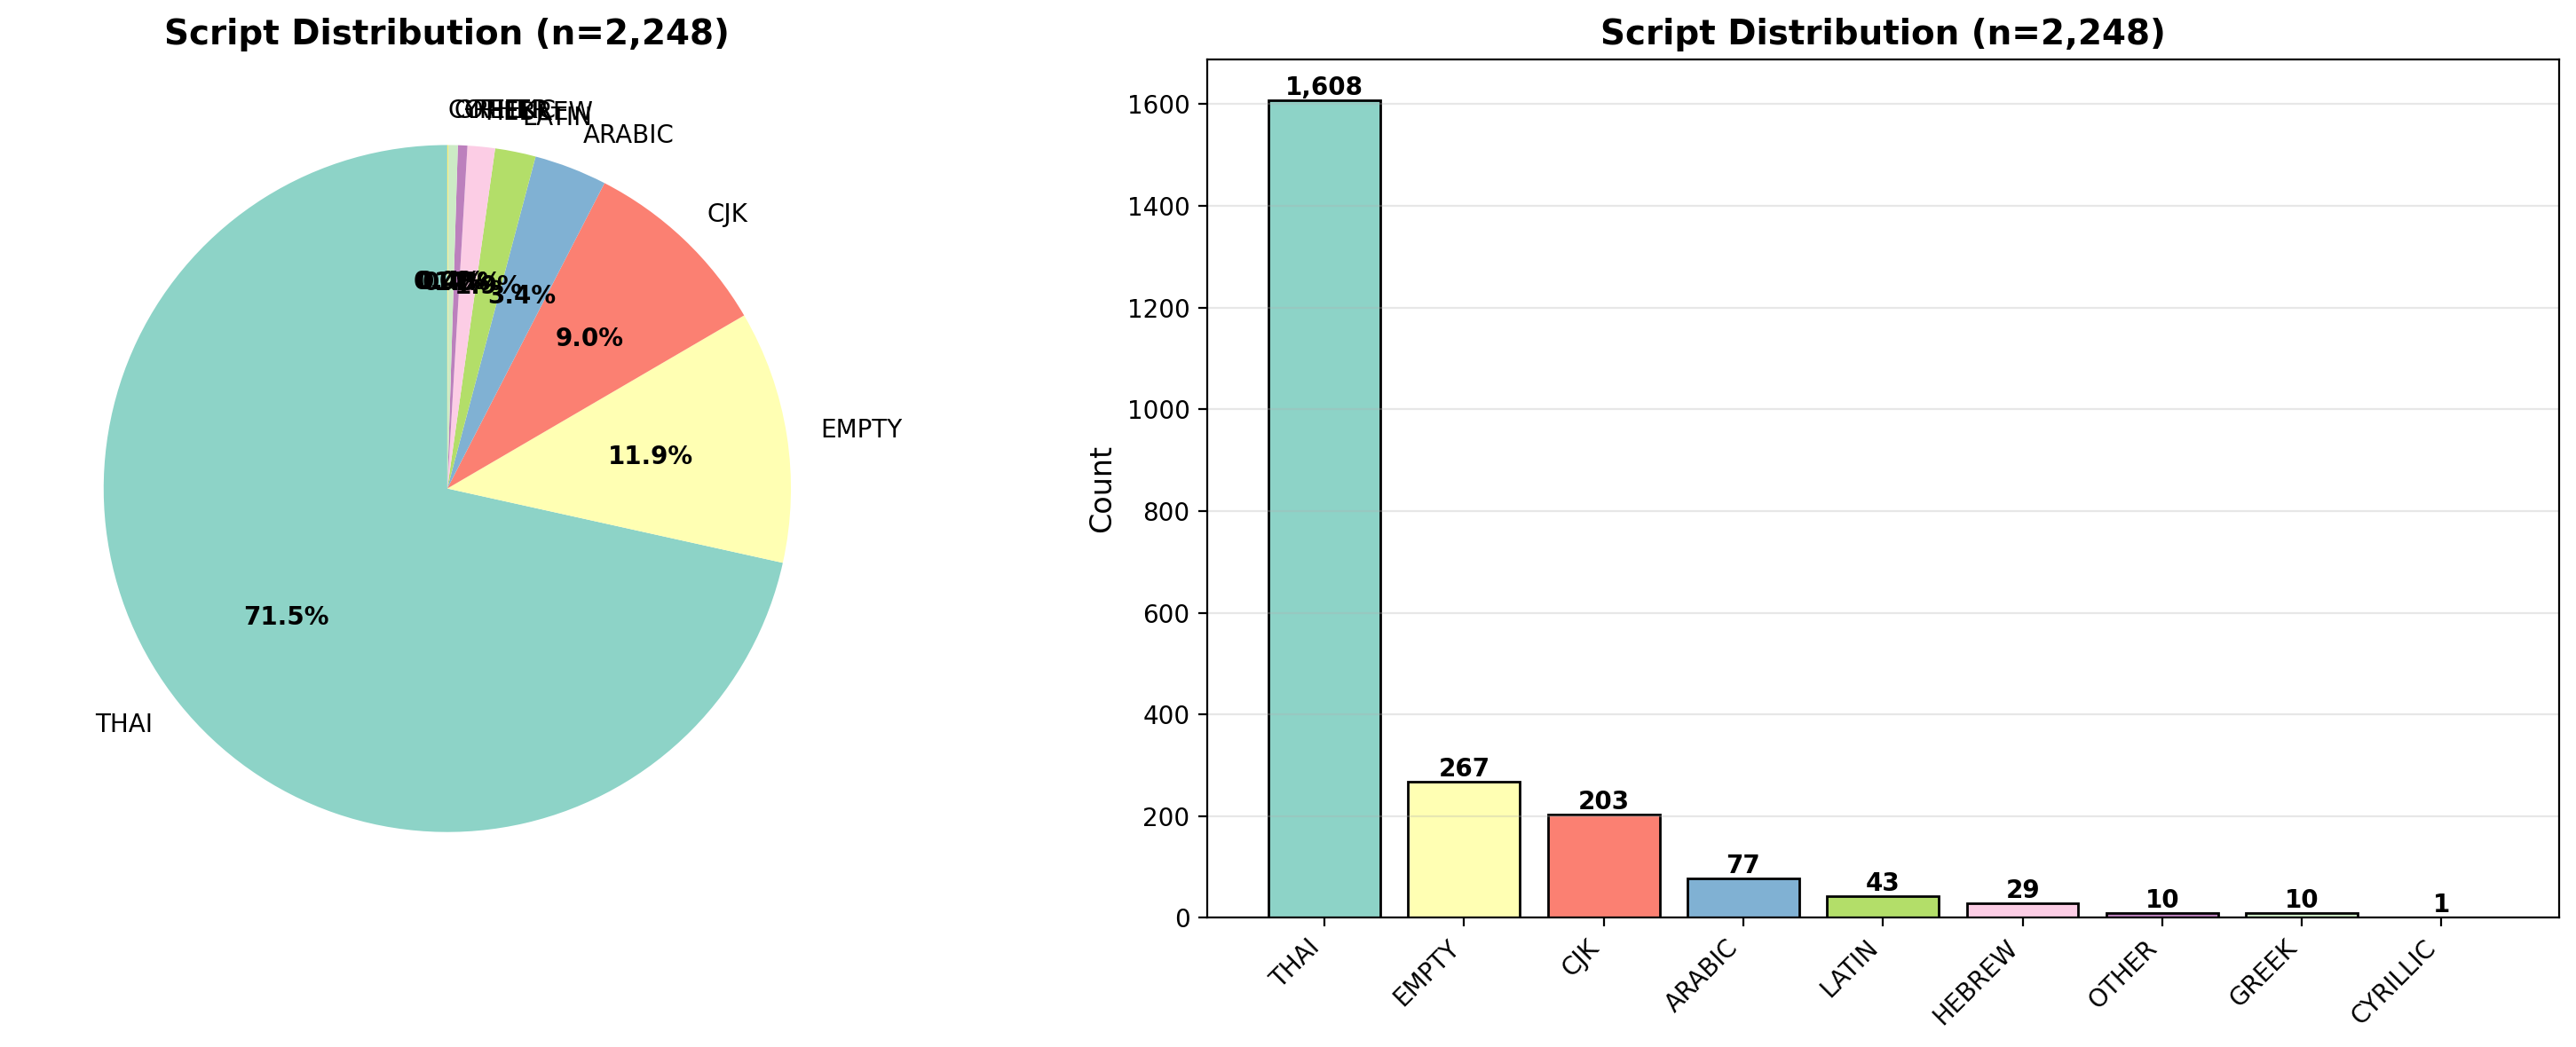

✓ Plotted script distribution


In [22]:
print("\nPlotting script distribution...\n")

# Prepare data for plotting
script_labels = [script for script, _ in script_counts.most_common()]
script_values = [count for _, count in script_counts.most_common()]

# Create figure with pie chart and bar chart side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6), dpi=DPI)

# Pie chart
colors = plt.cm.Set3(np.linspace(0, 1, len(script_labels)))
wedges, texts, autotexts = ax1.pie(
    script_values,
    labels=script_labels,
    autopct='%1.1f%%',
    colors=colors,
    startangle=90
)

# Make percentage text readable
for autotext in autotexts:
    autotext.set_color('black')
    autotext.set_fontweight('bold')
    autotext.set_fontsize(10)

ax1.set_title(f'Script Distribution (n={n_cluster:,})', fontsize=14, fontweight='bold')

# Bar chart
bars = ax2.bar(range(len(script_labels)), script_values, color=colors, edgecolor='black', linewidth=1)
ax2.set_xticks(range(len(script_labels)))
ax2.set_xticklabels(script_labels, rotation=45, ha='right')
ax2.set_ylabel('Count', fontsize=12)
ax2.set_title(f'Script Distribution (n={n_cluster:,})', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3, axis='y')

# Add counts on top of bars
for bar, count in zip(bars, script_values):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
             f'{count:,}',
             ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

print("✓ Plotted script distribution")

## Token ID Distribution Histogram


Plotting token ID distribution...



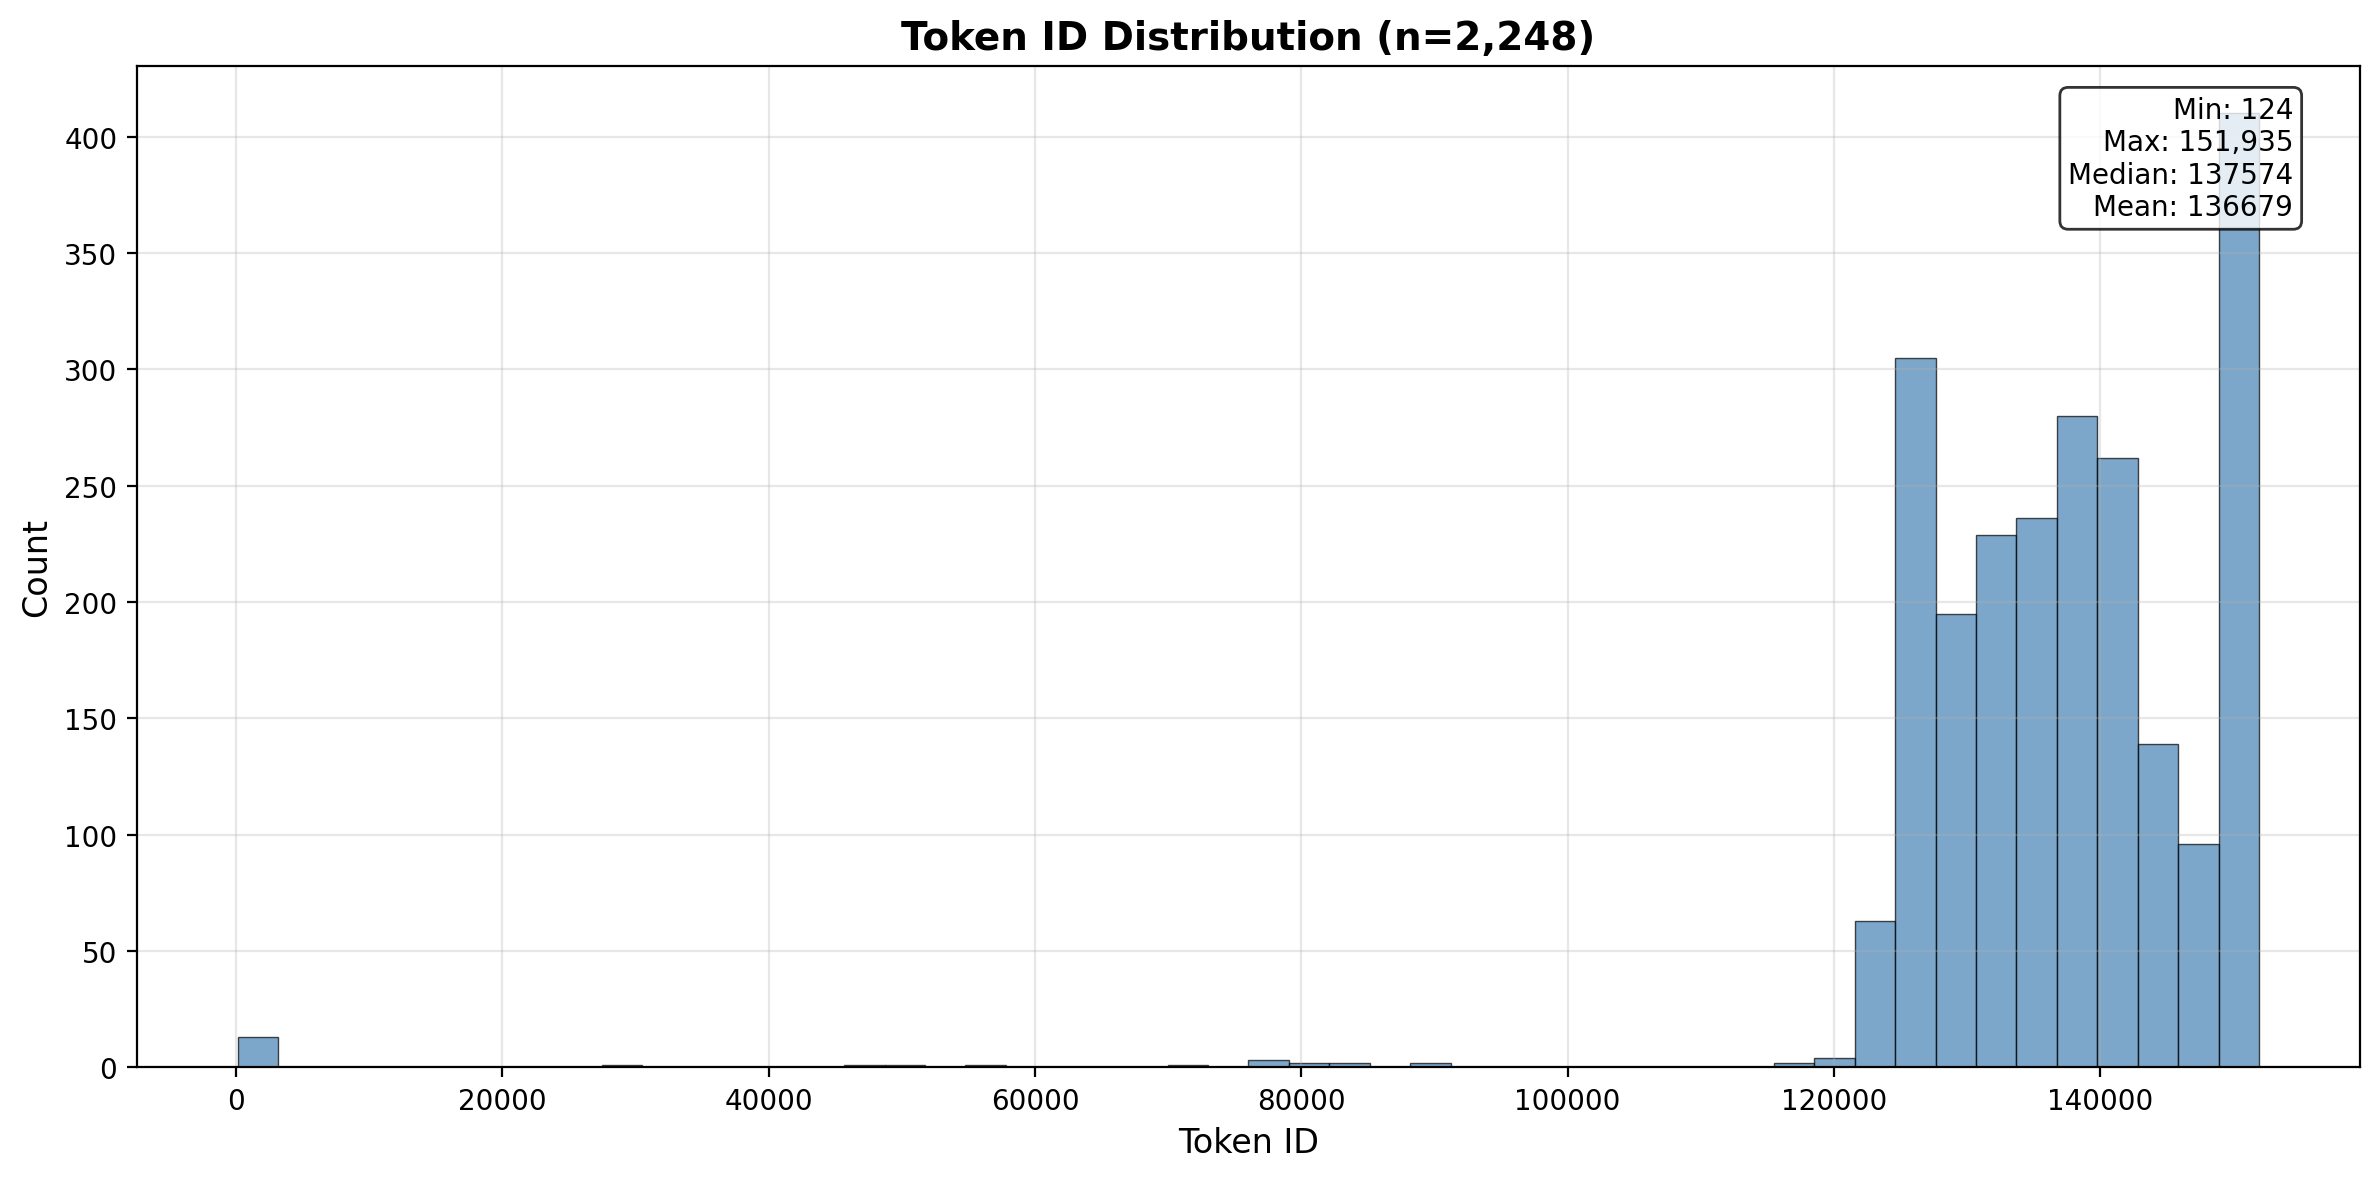

✓ Plotted token ID distribution


In [23]:
print("\nPlotting token ID distribution...\n")

fig, ax = plt.subplots(figsize=(12, 6), dpi=DPI)

ax.hist(ids_np, bins=50, color='steelblue', alpha=0.7, edgecolor='black', linewidth=0.5)
ax.set_xlabel('Token ID', fontsize=12)
ax.set_ylabel('Count', fontsize=12)
ax.set_title(f'Token ID Distribution (n={n_cluster:,})', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)

# Add stats
stats_text = f"Min: {ids_np.min():,}\n"
stats_text += f"Max: {ids_np.max():,}\n"
stats_text += f"Median: {np.median(ids_np):.0f}\n"
stats_text += f"Mean: {ids_np.mean():.0f}"
ax.text(0.97, 0.97, stats_text,
        transform=ax.transAxes, fontsize=10,
        verticalalignment='top', horizontalalignment='right',
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

print("✓ Plotted token ID distribution")

## Outlier Analysis

In [24]:
print("\nAnalyzing outliers (top 20 by radius)...\n")

# Sort by radius
sorted_indices = r.argsort(descending=True)

# Show top 20
print(f"{'Rank':<6} {'Token ID':<10} {'Radius':<12} {'Decoded':<30} {'Script'}")
print("-" * 80)

for rank in range(min(20, n_cluster)):
    idx = sorted_indices[rank]
    token_id = cluster_token_ids[idx].item()
    radius = r[idx].item()
    decoded = decoded_tokens[idx]
    script = scripts[idx]
    
    # Truncate decoded for display
    decoded_display = repr(decoded)[:28] + '..' if len(repr(decoded)) > 30 else repr(decoded)
    
    print(f"{rank+1:<6} {token_id:<10} {radius:<12.8f} {decoded_display:<30} {script}")


Analyzing outliers (top 20 by radius)...

Rank   Token ID   Radius       Decoded                        Script
--------------------------------------------------------------------------------
1      71473      0.11260527   '(EFFECT'                      LATIN
2      48494      0.11184927   'bstract'                      LATIN
3      122347     0.03672947   '忞'                            CJK
4      139809     0.02079694   ' chặ'                         LATIN
5      137722     0.01560331   'nızda'                        LATIN
6      148664     0.00753114   '헸'                            OTHER
7      141054     0.00515923   ' беременн'                    CYRILLIC
8      76035      0.00472136   ' datingside'                  LATIN
9      141591     0.00427708   'تلفزي'                        ARABIC
10     117971     0.00379758   '力还是自'                         CJK
11     138463     0.00248973   ' כאיל'                        HEBREW
12     138112     0.00166448   ' paździ'                  

## Special Focus: The Perpendicular Pair

In [25]:
print("\n" + "="*60)
print("THE PERPENDICULAR PAIR (71473 and 48494)")
print("="*60)
print()

# Find these tokens in our arrays
idx_71473 = (cluster_token_ids == 71473).nonzero(as_tuple=True)[0]
idx_48494 = (cluster_token_ids == 48494).nonzero(as_tuple=True)[0]

if len(idx_71473) > 0 and len(idx_48494) > 0:
    idx_71473 = idx_71473[0].item()
    idx_48494 = idx_48494[0].item()
    
    print(f"Token 71473:")
    print(f"  Decoded: {repr(decoded_tokens[idx_71473])}")
    print(f"  Script: {scripts[idx_71473]}")
    print(f"  Radius: {r[idx_71473].item():.8f}")
    print()
    print(f"Token 48494:")
    print(f"  Decoded: {repr(decoded_tokens[idx_48494])}")
    print(f"  Script: {scripts[idx_48494]}")
    print(f"  Radius: {r[idx_48494].item():.8f}")
    print()
    print("These two tokens form a near-perfect right triangle with the centroid:")
    print("  - Both ~1.1 units from centroid (3× the norm of centroid)")
    print("  - Separated by 1.6 units (√2 × 1.1 ≈ 1.56)")
    print("  - Angle at centroid: 90.16° (perpendicular!)")
else:
    print("Tokens 71473 and/or 48494 not found in cluster")

print()
print("="*60)


THE PERPENDICULAR PAIR (71473 and 48494)

Token 71473:
  Decoded: '(EFFECT'
  Script: LATIN
  Radius: 0.11260527

Token 48494:
  Decoded: 'bstract'
  Script: LATIN
  Radius: 0.11184927

These two tokens form a near-perfect right triangle with the centroid:
  - Both ~1.1 units from centroid (3× the norm of centroid)
  - Separated by 1.6 units (√2 × 1.1 ≈ 1.56)
  - Angle at centroid: 90.16° (perpendicular!)

